In [4]:
# These should already be installed on your workspace
!pip install --disable-pip-version-check --quiet -U langchain==0.2.16
!pip install --disable-pip-version-check --quiet -U langchain_openai==0.1.23
!pip install --disable-pip-version-check --quiet -U langgraph==0.2.19
!pip install --disable-pip-version-check --quiet -U langchainhub==0.1.21
!pip install --disable-pip-version-check --quiet -U tavily-python==0.4.0
!pip install --disable-pip-version-check --quiet -U langchain-community==0.2.16
!pip install --disable-pip-version-check --quiet -U python-dotenv==1.0.1

In [5]:
# Load in the OpenAI key and Tavily key.
# In the project folder, create a file named 'config.env'
# ensure your .env file contains keys named OPENAI_API_KEY="your key" and TAVILY_API_KEY="your key"
from dotenv import load_dotenv
import os 

load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

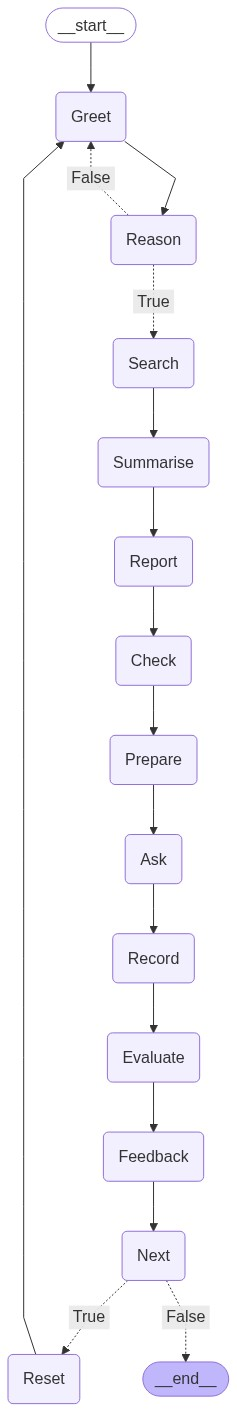



Hello patient!


What health topic or medical condition would you like to learn about?University of Hull


Apologies. This topic is outside my area of expertise.


Hello patient!


What health topic or medical condition would you like to learn about?Neuroblastoma


Excellent. Please give me a few seconds to prepare a lesson.


I hope this summary is useful!




Neuroblastoma is a type of cancer that primarily affects children under the age of 5, with the most common location being in the adrenal glands. It can also occur in other areas of the body such as the spine, belly, chest, and neck. Neuroblastoma arises from immature nerve cells called neuroblasts and is classified as an embryonal neuroendocrine tumor. The presentation of neuroblastoma can vary greatly, with symptoms depending on the location of the tumor.

Treatment for neuroblastoma is determined by the patient's risk group, which is classified as low risk, intermediate risk, or high risk. Factors such as age, tumor size, an

{'messages': [HumanMessage(content='University of Hull', id='a4b71de0-39e0-40c2-92b3-364d91fbd0bd'),
  AIMessage(content='ask', id='a8f26205-20fe-490e-8818-7710b99a06ae'),
  HumanMessage(content='Neuroblastoma', id='933b8536-6879-4e07-9d8f-979b9ecd72ee'),
  AIMessage(content='search', id='6ecdcbcf-0500-4381-a6d5-515ddec01cd0'),
  SystemMessage(content="Search results: 'Neuroblastoma'.", id='7195725e-20e1-45d1-bb1c-7c05890e4072'),
  AIMessage(content="Neuroblastoma is a type of cancer that primarily affects children under the age of 5, with the most common location being in the adrenal glands. It can also occur in other areas of the body such as the spine, belly, chest, and neck. Neuroblastoma arises from immature nerve cells called neuroblasts and is classified as an embryonal neuroendocrine tumor. The presentation of neuroblastoma can vary greatly, with symptoms depending on the location of the tumor.\n\nTreatment for neuroblastoma is determined by the patient's risk group, which is c

In [6]:
#Import the libraries necessary for the AI agent.
import time 
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
import re

# Helper functions
def display_text_to_user(text):
    """
    This helper function prints static messages to the user.
    """
    print(text) 
    time.sleep(1) # wait for it to render before asking for input or it'll never show up.
    
def ask_user_for_input(input_description):
    """
    This helper function requests an input from the user and records their response.
    """    
    response = input(input_description)
    return response

#This class is a subclass of MessageState (LangGraph).
class State(MessagesState):
    query: str
    search_results: str
    summary: str
    quiz: str
    answer: str
    evaluation: str

#Initialise and parameterise an LLM for the AI agent.
model = ChatOpenAI(temperature=0, streaming=True, 
                   openai_api_key=os.getenv("OPENAI_API_KEY"), openai_api_base="https://openai.vocareum.com/v1"
                  )

#Initialise a workflow as an instance of StateGraph (LangGraph).
workflow = StateGraph(State)

# nodes
def step_1(state):
    """
    Greet the user and request an input to find out the topic of interest. Record their response.
    """
    #print('\n\nstep_1 called', state)
    display_text_to_user('\n\nHello patient!')
    query = ask_user_for_input('\n\nWhat health topic or medical condition would you like to learn about?')
    user_message = {"role": "user", "content": query}
    return {**state, "query": query, "messages": state["messages"] + [user_message]}

def step_2(state):
    """
    ReAct agent. Use the LLM to decide whether the user's input is relevant.
    """    
    #print('\n\nstep_2 called', state)    
    query = state["query"]
    prompt = (
        "Your job is to help patients learn about health topics and medical conditions.\n\n"
        "Your immediate task is to decide whether the patient's input is relevant to your job or not.\n\n"
        f"Patient's input: {query}\n\n"
        "If it is a relevant input, respond with 'search'. If it is not, respond with 'ask'."
    )  
    response = model.invoke(prompt).content.strip().lower()
    assistant_message = {"role": "assistant", "content": response}
    return {**state, "messages": state["messages"] + [assistant_message]}

def router_afterstep2(state):
    """
    ReAct agent. Select an action based on the user's input.
    """    
    #print('\n\nrouter after step 2 called', state)
    assistant_msg = state["messages"][-1]
    action = assistant_msg.content
    if "search" in action:
        print("\n\nExcellent. Please give me a few seconds to prepare a lesson.")
        return True
    elif "ask" in action:
        print("\n\nApologies. This topic is outside my area of expertise.")
        return False
    return False

def step_3(state):
    """
    Tool use. Search the web for information about the topic of interest.
    """       
    #print('\n\nstep_3 called', state)
    query = state["query"]
    search = TavilySearchResults()
    search_results = search.invoke(query)
    system_message = {"role": "system", "content": f"Search results: '{query}'."}
    return {**state, "search_results": search_results, "messages": state["messages"] + [system_message]}

def step_4(state):
    """
    Use the LLM to summarise the search results.
    """    
    #print('\n\nstep_4 called', state)
    search_results = state["search_results"]
    search_results_list = []
    for result in search_results:
        search_results_list.append(result.get("content", ""))
    notes = "\n\n".join(search_results_list)
    prompt = (
        f"Generate a summary of the following notes for the purpose of patient education:\n\n{notes}\n\n"
        "Style: Produce three to four paragraphs for the summary."
    )
    response = model.invoke(prompt).content
    assistant_message = {"role": "assistant", "content": response}
    return {**state, "summary": response, "messages": state["messages"] + [assistant_message]}

def step_5(state):
    """
    Display the generated summary to the user as a static message.
    """    
    #print('\n\nstep_5 called', state)
    display_text_to_user('\n\nI hope this summary is useful!\n\n\n\n')
    display_text_to_user(state["summary"])
    return state

def step_6(state):
    """
    Invite the user to complete a comprehension check and record their response.
    """       
    #print('\n\nstep_6 called', state)
    while True:
        signal = ask_user_for_input('\n\nAre you ready for a comprehension check? When you are, type "yes"')
        if re.sub(r'[\s\W_]+', '', signal.lower()) == 'yes':
            break
    return state

def step_7(state):
    """
    Use the LLM to generate a question for the comprehension check based on the summary.
    """      
    #print('\n\nstep_7 called', state)
    summary = state["summary"]
    prompt = (
        "Instruction: Based on the following summary, generate a single, open-ended, and relevant quiz question for a patient.\n\n"
        f"Context: {summary}.\n\n"
        "Style: Assume that the patient is an educated adult who knew nothing about the topic or condition before reading the summary. Be clear and concrete. Avoid open-ended questions. Include one concept in the question only."
    )
    response = model.invoke(prompt).content
    assistant_message = {"role": "assistant", "content": response}
    return {**state, "quiz": response, "messages": state["messages"] + [assistant_message]}

def step_8(state):
    """
    Display the generated question to the user as a static message.
    """     
    #print('\n\nstep_8 called', state)
    display_text_to_user("\n\nExcellent! Here's the question.\n\n")
    display_text_to_user(state["quiz"])
    return state

def step_9(state):
    """
    Request and record the user's answer to the comprehension check question.
    """    
    #print('\n\nstep_9 called', state)
    answer = ask_user_for_input('\n\nPlease enter your answer.')
    user_message = {"role": "user", "content": answer}
    return {**state, "answer": answer, "messages": state["messages"] + [user_message]}

def step_10(state):
    """
    Use the LLM to evaluate the user's answer by comparing it with the question and summary.
    """    
    #print('\n\nstep_10 called', state)
    answer = state["answer"]
    question = state["quiz"]
    summary = state["summary"]
    prompt = (
        "Instruction: Evaluate the patient's response to the question by comparing it with the question and summary. Provide a grade and an explanation.\n\n"
        f"Patient's response: {answer}.\n\n"
        f"Question: {question}.\n\n"
        f"Summary: {summary}.\n\n"      
        "Grading scale: Grade the response on a scale from A (perfect) to F (total failure).\n\n"
        "Criteria: Reward accuracy. Penalise irrelevant information.\n\n"
        "Style: The explanation should include relevant citations from the summary to reinforce learning. Use a kind and respectful tone."
    )
    evaluation = model.invoke(prompt).content
    assistant_message = {"role": "assistant", "content": evaluation}
    return {**state, "evaluation": evaluation, "messages": state["messages"] + [assistant_message]}

def step_11(state):
    """
    Display the generated grade and feedback to the user as a static message.
    """       
    #print('\n\nstep_11 called', state)
    display_text_to_user("\n\nHere's your grade, followed by my feedback.\n\n")
    display_text_to_user(state["evaluation"])
    return state

def step_12(state):
    """
    Find out if the user is interested in another topic. Record their response.
    """    
    #print('\n\nstep_12 called', state)
    while True:
        response = ask_user_for_input('\n\nWould you like to learn about another health topic? Type "yes" or "no".')
        response_clean = re.sub(r'[\s\W_]+', '', response.lower())
        if response_clean == 'yes' or response_clean == 'no':
            break
    user_message = {"role": "user", "content": response_clean}
    return {**state, "messages": state["messages"] + [user_message]}

def router_afterstep12(state):
    """
    Select an action based on the user's input.
    """    
    #print('\n\nrouter after step 12 called', state)
    user_msg = state["messages"][-1]
    restart = user_msg.content
    if restart == "yes":
        print("\n\nLet's learn something else!")
        return True
    elif restart == "no":
        print("\n\nSee you next time!")
        return False
    return False

def step_13(state):
    """
    Reset the state before finding out the new health topic or medical condition.
    """     
    #print('\n\nstep_13 called', state)    
    print('\n\nCreating a new state')
    return {"messages": []}

#Define the workflow as a graph.

#Add the nodes to the graph.
workflow.add_node("Greet", step_1)
workflow.add_node("Reason", step_2)
workflow.add_node("Search", step_3)
workflow.add_node("Summarise", step_4)
workflow.add_node("Report", step_5)
workflow.add_node("Check", step_6)
workflow.add_node("Prepare", step_7)
workflow.add_node("Ask", step_8)
workflow.add_node("Record", step_9)
workflow.add_node("Evaluate", step_10)
workflow.add_node("Feedback", step_11)
workflow.add_node("Next", step_12)
workflow.add_node("Reset", step_13)

#Add edges to connect the nodes.
workflow.add_edge(START, "Greet")
workflow.add_edge("Greet", "Reason")
workflow.add_conditional_edges("Reason", router_afterstep2, {True: "Search", False: "Greet"})
workflow.add_edge("Search", "Summarise")
workflow.add_edge("Summarise", "Report")
workflow.add_edge("Report", "Check")
workflow.add_edge("Check", "Prepare")
workflow.add_edge("Prepare", "Ask")
workflow.add_edge("Ask", "Record")
workflow.add_edge("Record", "Evaluate")
workflow.add_edge("Evaluate", "Feedback")
workflow.add_edge("Feedback", "Next")
workflow.add_conditional_edges("Next", router_afterstep12, {True: "Reset", False: END})
workflow.add_edge("Reset", "Greet")

#Checkpointing mechanism in LangGraph.
#It saves the state's history (each step's state) during one execution of the workflow.
memory = MemorySaver()

#Compile the defined workflow.
app = workflow.compile(checkpointer=memory)

#Visualise the workflow as a graph.
display(Image(app.get_graph().draw_mermaid_png()))

#Configure an execution of the workflow.
config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "2"})  

#Initialise the state, which will be transformed during the execution.
initial_state = {"messages": [],}

#Execute the workflow.
app.invoke(
    initial_state,
    config,
)